# Topic_Modeling_Bertopic

Notebook donde se entrena el modelo BERTopic para modelado de temas

In [1]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [2]:
import pandas as pd
from bertopic import BERTopic
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from umap import UMAP

from gensim.models import CoherenceModel
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.matutils import corpus2csc

from sentence_transformers import SentenceTransformer

2025-07-13 09:16:50.476776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752398210.671824      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752398210.728724      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [12]:
def clean_text(text):
    """
    Lightly clean tweets for BERTopic (BERT-based models).
    Preserves stopwords and sentence structure for semantic understanding.

    Removes: HTML tags, URLs, mentions, hashtag symbols.
    """
    import re

    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)  # Remove URLs
    text = re.sub(r"@\w+", '', text)  # Remove mentions
    text = re.sub(r"#", '', text)  # Remove hashtag symbol only
    return text.strip().lower()

In [14]:
df1 = pd.read_csv("/kaggle/input/fake-or-real-news/fake_or_real_news.csv")
df1=df1['title']+"\n"+df1['text']

df2 = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/test.csv", encoding='ISO-8859-1')
df2 = df2['text']

df3 = pd.read_csv("/kaggle/input/sentiment-analysis-dataset/train.csv", encoding='ISO-8859-1')
df3 = df3['text']

df = pd.concat([df1,df2,df3], ignore_index=True)

df = df.fillna('').astype(str)
df = df.astype(str).apply(clean_text)

df = df.dropna(how='all')



#docs_subset = df.sample(frac=0.5, random_state=42).to_list()  # 20% del total

docs = df.to_list()
joined_text = " ".join(docs)

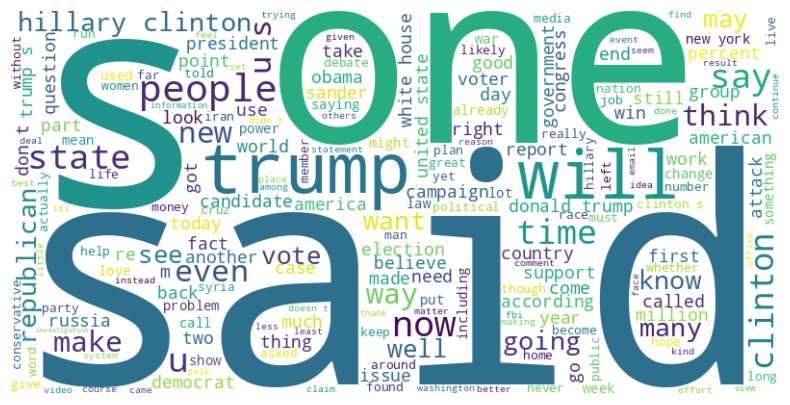

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Crear la nube
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate(joined_text)

# Mostrarla
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [20]:
hdbscan_model = HDBSCAN(min_cluster_size=53, min_samples=18, prediction_data=True)
vectorizer_model = CountVectorizer(
    max_df=0.95,  # elimina palabras que aparecen en >95% de los docs
    min_df=2,     # elimina palabras que aparecen en <2 documentos
    #max_features=1000,
    stop_words="english"
)
ctfidf_model = ClassTfidfTransformer(bm25_weighting=True)

umap_model = UMAP(n_neighbors=25, n_components=30)#, min_dist=0.26817245166400844, metric="cosine")

model = BERTopic(vectorizer_model=vectorizer_model,
                 verbose=True,
                 embedding_model='all-MiniLM-L6-v2', 
                 #nr_topics=150,
                 #embedding_model= 'sentence-t5-base',#'all-mpnet-base-v2',#'paraphrase-MiniLM-L3-v2',
                 #ctfidf_model=ctfidf_model,
                 umap_model = umap_model,
                 hdbscan_model=hdbscan_model,
                 calculate_probabilities=True
                 #language='english'
                )

topics, _ = model.fit_transform(docs)

2025-07-13 09:33:45,434 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1208 [00:00<?, ?it/s]

2025-07-13 09:34:11,281 - BERTopic - Embedding - Completed ✓
2025-07-13 09:34:11,282 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-07-13 09:35:01,004 - BERTopic - Dimensionality - Completed ✓
2025-07-13 09:35:01,015 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-07-13 09:35:26,920 - BERTopic - Cluster - Completed ✓
2025-07-13 09:35:26,930 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-07-13 09:35:30,720 - BERTopic - Representation - Completed ✓


In [22]:
info = model.get_topic_info()
info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,16551,-1_lol_good_love_im,"[lol, good, love, im, today, day, got, fun, li...",[i always have a good day! i make it good all ...
1,0,6100,0_trump_said_clinton_people,"[trump, said, clinton, people, state, presiden...",[“where is the public outcry for an explanatio...
2,1,1259,1_ow_sponsor_thats_,"[ow, sponsor, thats, , , , , , , ]","[, , ]"
3,2,1004,2_twitter_tweet_tweets_tweetdeck,"[twitter, tweet, tweets, tweetdeck, tweeting, ...","[first time to twitter.., new on twitter, bein..."
4,3,990,3_eat_lunch_eating_chocolate,"[eat, lunch, eating, chocolate, cream, hungry,...",[... lunch is no fun when you have nothing to ...
...,...,...,...,...,...
70,69,56,69_party_partying_tomorrow_tonight,"[party, partying, tomorrow, tonight, alright, ...",[@ sly party enjoying life partying tonight.....
71,70,56,70_dismantling_obamacare_pushing_killing,"[dismantling, obamacare, pushing, killing, ref...",[obamacare's unlikely no. 1 city\nkilling obam...
72,71,55,71_vote_voted_voting_wont,"[vote, voted, voting, wont, pls, mtv, miley, l...",[what that`s not fair i can`t vote it says the...
73,72,54,72_password_email_messages_spam,"[password, email, messages, spam, gmail, email...","[now i remembered the password, sachie: yna do..."


In [ ]:
model.get_representative_docs()

In [ ]:
model.visualize_topics(top_n_topics=30)

In [ ]:
model.visualize_barchart()

In [23]:
from sentence_transformers import SentenceTransformer, util
import numpy as np
import torch

def semantic_coherence(topic_model, model_name='all-MiniLM-L6-v2', top_n=10):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = SentenceTransformer(model_name).to(device)
    
    scores = []
    for topic_id in topic_model.get_topic_info()["Topic"]:
        if topic_id == -1:
            continue
        topic_words = [word for word, _ in topic_model.get_topic(topic_id)[:top_n]]
        embeddings = model.encode(topic_words, convert_to_tensor=True, device=device)
        sim_matrix = util.pytorch_cos_sim(embeddings, embeddings).cpu().numpy()
        upper_triangle = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
        if len(upper_triangle) > 0:
            scores.append(np.mean(upper_triangle))
    
    return np.mean(scores)
semantic_coherence(model, model_name='all-MiniLM-L6-v2', top_n=10)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.40023386

In [ ]:
# Guardar el modelo entrenado
model.save("/kaggle/working/modelo_bertopic", save_embedding_model=False)